# Assignment 5
## Decision Trees and Random Forests for Regression, Part 2

### About this notebook

The general description and instructions as well as questions for the work with Part 2 of the assignment (this notebook) are found in the Assignment description in Canvas!


In [27]:
# YOU DON'T HAVE TO RUN THIS IF EVERYTHING IS ALREADY INSTALLED CORRECTLY
!pip3 install --upgrade pip
!pip3 install graphviz
!pip3 install dtreeviz
!pip3 install numpy scipy

!pip3 install ordered_set

## Step 0: Dataset(s)

First load the dataset you want to use. Ultimately, you should be working with the **California housing data**, but for quicker test runs, it might help to first start out with the **Diabetes data**. For an initial test that your implementation actually works correctly, you should use the **ConceptData**.

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
import graphviz

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

test_case = 'concept'
#test_case = 'california'
#test_case = 'diabetes'

if test_case == 'california':
    dataset = fetch_california_housing()
elif test_case == 'diabetes':
    dataset = load_diabetes()
elif test_case == 'concept':
    print("running on toy data, actual data will be loaded later")
else:
    raise ValueError('Unknown test case')



running on toy data, actual data will be loaded later


If using real data, split the set into train, validation and test sets.

In [29]:
if (test_case == 'california') or (test_case == 'diabetes'):
    X = dataset.data
    y = dataset.target

    train_ratio = 0.70
    validation_ratio = 0.15
    test_ratio = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)
    

## Steps 1-2: Creating and evaluating an ID3-based Regression Tree

The following cells provide some framework for creating / testing your own, ID3-based, regressor. To see that your tree is constructed correctly, some prints are provided (essentially from the lecture) within the handout directory, that are created with the "ConceptData" from the lecture. 

### Step 1:
To make experiments with categorical data, you need to discretize - bin - the data (this goes both for the 'california' and the 'diabetes' cases, for the toy data - 'concept' - case, this is naturally given, note that the data are only loaded below). 
In order to have the entire data set "as is" for the binning, you can prepare a binning rule on the original data (X), that you then apply to your train and test data sets. To make sure that you do not miss any possible attribute values, use the entire set (X) again when providing the categorical values (here bin indices) to the ID3 tree.

In [30]:
feature_names = dataset.feature_names
mins = X.min(axis=0)
maxs = X.max(axis=0)
for name, lo, hi in zip(feature_names, mins, maxs):
    print(f"{name:12s} {lo:7.3f} … {hi:7.3f}")

import pandas as pd
df = pd.DataFrame(X, columns=dataset.feature_names)
print(df.describe().loc[['min','25%','50%','75%','max','std']])
print("偏度 (skew):")
print(df.skew())



MedInc         0.500 …  15.000
HouseAge       1.000 …  52.000
AveRooms       0.846 … 141.909
AveBedrms      0.333 …  34.067
Population     3.000 … 35682.000
AveOccup       0.692 … 1243.333
Latitude      32.540 …  41.950
Longitude    -124.350 … -114.310
        MedInc   HouseAge    AveRooms  AveBedrms    Population     AveOccup  \
min   0.499900   1.000000    0.846154   0.333333      3.000000     0.692308   
25%   2.563400  18.000000    4.440716   1.006079    787.000000     2.429741   
50%   3.534800  29.000000    5.229129   1.048780   1166.000000     2.818116   
75%   4.743250  37.000000    6.052381   1.099526   1725.000000     3.282261   
max  15.000100  52.000000  141.909091  34.066667  35682.000000  1243.333333   
std   1.899822  12.585558    2.474173   0.473911   1132.462122    10.386050   

      Latitude   Longitude  
min  32.540000 -124.350000  
25%  33.930000 -121.800000  
50%  34.260000 -118.490000  
75%  37.710000 -118.010000  
max  41.950000 -114.310000  
std   2.135952    2

Features with more skewed distributions, longer tails, or wider ranges should be assigned more bins

In [31]:
from ConceptDataRegr import ConceptDataRegr
import ConceptDataRegr as cd

from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# For testing that you get the correct output from the ID3 / your score implementation, 
# you can use the "ConceptData" data set (toggle in step 0!):
if test_case == 'concept' :
    attributes, binned_X_train, y_train, binned_X_test, y_test = cd.ConceptDataRegr().get_data()
    binned_X_val = []
    y_val = []
     
else :
    # you might want to try different numbers of bins to see whether using a multivalued branching actually can 
    # improve results over binary decisions only
    
    # ΝΟΤΕ: it is NOT necessary to use the same number of bins for all parameters, e.g. [3,11,4,2,2,7,8,3]
    # could be a really good choice for the California data - or not (no idea if it is, this is just an EXAMPLE)
    
    # HINT: inspect the data set description in part 1 to find suitable numbers - there is, for example, 
    # one feature in the Diabetes data that is binary by nature, so it does not make sense to use anything 
    # else but two bins for that feature
    
    if test_case == 'california':
        #bins = [2,2,2,2,2,2,2,2]
        #bins = [6, 5, 7, 7, 6, 6, 5, 5]
        bins = [3,11,4,2,2,7,8,3]
    elif test_case == 'diabetes':
        bins = [2,2,2,2,2,2,2,2,2,2]
        
    # here you can test to use different strategies, see the KBinsDiscretizer documentation
    binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    binning_rule = binner.fit(X)
    # use the binning rule
    binned_X = binning_rule.transform(X).astype(int)
    binned_X_train = binning_rule.transform(X_train).astype(int)
    binned_X_val = binning_rule.transform(X_val).astype(int)
    binned_X_test = binning_rule.transform(X_test).astype(int)

    # create an attribute list with "conceptual" features/attributes
    attributes = {}
    i = 0
    for attr in dataset.feature_names :
        attributes[attr] = set(binned_X[:,i])
        i+=1

print(attributes)

{'wind': ['strong', 'weak'], 'airTemp': ['warm', 'cold'], 'humidity': ['normal', 'high'], 'sky': ['sunny', 'cloudy', 'rainy'], 'waterTemp': ['warm', 'cool'], 'forecast': ['same', 'change']}


### Step 2:
Set up and fit the tree, create the dot-data for visualisation. Fill the stubb for *id3_score* below and compare results against the sklearn implementation using different parameters for *max_depth* and *min_samples_leaf*, as well as (many) different binnings. 

Evaluate (on the **California housing data**) two different parameter settings for *max_depth* and *min_samples_leaf* each as well as *two different binnings* (where one should be a binary binning for direct comparison with the SKLearn tree model) in a structured way (e.g. produce a table with the different combinations of parameters). Compare against the **respective same parameter settings** (where possible) for regressor1 from Part 1. 
Hint: there are binnings (non-uniform such) for which the ID3 actually outperforms the CART implementation in SciKitLearn.

Do **not** try to compare to the random forest score from Part 1, that will be the next step!!!

SSres = Σ (y_pred − y_true)²

SStot = Σ (y_true − y_mean)²

R2=1−​SSres​​/SStot

In [32]:
# -------------------------- IMPLEMENTATION TASK BELOW THIS LINE ------------------------  
import ID3_reg

# As of now, the ID3_reg class does not provide any score-method - please replace the stubb below by
# a proper method according to the description of DecisionTreeRegressor.score() for easier 
# comparison with the scikit-learn trees!
    
def id3_score(predicted, target) :
    score = 1.0
        
        # ************************************************
        # Implement your score method here
        # ************************************************
         # R^2 = 1 - SS_res / SS_tot
    
    predicted = np.array(predicted, dtype=float)
    target = np.array(target, dtype=float)
    
    # residual sum of squares
    ss_res = np.sum((target - predicted)**2)
    
    # total sum of squares (same definition as sklearn)
    y_mean = np.mean(target)
    ss_tot = np.sum((target - y_mean)**2)

    # handle edge case: constant target values (ConceptData case!)
    if ss_tot == 0:
        score = -ss_res / 1e-10   # avoids division by zero, produces ≈ -4.0 in ConceptData
    else:
        score = 1 - ss_res/ss_tot
    return score

# -------------------------------------------------------------------------------------------------

# Now, set up the tree (inspect the ID3_reg class to see the different parameter options, start out with the
# "Concept Data" from the lecture)    
id3 = ID3_reg.ID3RegressionTreePredictor()

# Note: the implementation needs both the complete dictionary over all attributes plus the list of 
# attributes (names only) that are actually to be used for the particular run of fit()
myTree = id3.fit(binned_X_train, y_train, attributes, attributes.keys())

In [33]:
# Do a prediction and scoring on the binned validation and / or test data
predicted = id3.predict(binned_X_test)
print(binned_X_test, predicted) # OBS: printing does not make sense with the "real data"

id3_score(predicted, y_test)

#for diabetes
pred_train = id3.predict(binned_X_train)
pred_test = id3.predict(binned_X_test)

print("train score:", id3_score(pred_train, y_train))
print("test score:", id3_score(pred_test, y_test))


[['strong', 'warm', 'normal', 'cloudy', 'warm', 'change'], ['strong', 'warm', 'normal', 'sunny', 'warm', 'change']] [np.float64(0.9), np.float64(0.9)]
train score: 1.0
test score: -3.9999999999999982


### Diabetes ID3 Analyse:
| Aspect                     | CART-based sklearn Regressor                               | ID3-based Regression Tree (Your Implementation)                        |
|----------------------------|-------------------------------------------------------------|-------------------------------------------------------------------------|
| Tree structure             | Always **binary splits**                                     | **Multi-way splits** (one branch per category)                          |
| Feature type support       | Works directly with **continuous features**                 | Requires **categorical features only** → needs **binning**              |
| Split selection criterion  | Minimizes **MSE** and finds optimal numerical thresholds    | Maximizes **variance reduction** (information gain variant)             |
| Handling of thresholds     | **Automatic continuous threshold search**                   | Thresholds come only from **bins**; no continuous optimization          |
| Sensitivity to binning     | **Not sensitive** to bin choices                            | **Highly sensitive**: bin count strongly changes tree structure         |
| Pruning / stopping rules   | Supports max_depth, min_samples_leaf, cost-complexity prune | Original ID3 has **no pruning**, grows until attributes/samples exhaust |
| Overfitting tendency       | Moderate → controllable                                      | **Very high**, especially without stopping criteria                     |
| Interpretability           | Binary structure → easier to visualize                      | Many-way nodes can become complex quickly                               |
| Generalization ability     | Usually **good**, stable test performance                   | Poor generalization without pruning; test score often negative          |
| Performance on Diabetes    | Stable R² (≥0)                                              | Train ≈ 0.79, Test ≈ −0.6 (typical overfitting)                         |
| Performance dependency     | Depends on hyperparameters (max_depth, leaf size)           | Depends on **binning strategy** + tree depth (no stop → huge variance)  |


Since all features are discretized into bins, the tree performs coarse multi-way splits and rapidly produces leaf nodes with very few samples.
As a result, the model almost memorizes the training data (R² ≈ 0.79) but generalizes extremely poorly to unseen data (R² ≈ −0.6).
In contrast, CART in sklearn uses binary splits, continuous threshold optimization, and pruning mechanisms, making it far more robust and better generalizing.

In [34]:
# from sklearn.tree import DecisionTreeRegressor

# # CART-A: shallow + strong regularization
# models = [
#     ("A (md=1, leaf=20)", DecisionTreeRegressor(max_depth=1,min_samples_leaf=20, random_state=0)),
#     ("B (md=1, leaf=1)",  DecisionTreeRegressor(max_depth=1,min_samples_leaf=1, random_state=0)),
#     ("C (md=8, leaf=20)", DecisionTreeRegressor(max_depth=8,min_samples_leaf=20, random_state=0)),
#     ("D (md=8, leaf=1)",  DecisionTreeRegressor(max_depth=8,min_samples_leaf=1, random_state=0)),
# ]

# for name, model in models:
#     model.fit(X_train, y_train)
#     print(f"\nModel {name}")
#     print("Test R²:", model.score(X_test, y_test))
#     #print("CV Mean:", cross_val_score(model, X_train, y_train, cv=10).mean())


### Comparison of ID3 vs CART (California Housing)

| Binning Strategy        | CART max_depth | CART min_samples_leaf | ID3 R² | CART R² | Notes |
|-------------------------|----------------|------------------------|--------|---------|--------|
| 2-bin (binary)          | 1              | 20                     | 0.35140614724235586 | 0.2958635051924463 | Very simple model vs very coarse ID3 |
| 2-bin (binary)          | 8              | 1                      | 0.35140614724235586 | 0.6799595610932476 | High-complexity CART vs overfitting ID3 |
| Multi-bin (non-uniform) | 1              | 20                     | 0.547606028024936 | 0.2958635051924463 | Multi-bin gives ID3 more flexibility |
| Multi-bin (non-uniform) | 8              | 1                      | 0.547606028024936 | 0.6799595610932476 | Highest-variance setting for both models |

1. multi-way splits are better and capture more structure in the data.
2. CART with strong regularization (max_depth=1, min_samples_leaf=20) underfits (test R² ≈ 0.296), while a deeper CART (max_depth=8, min_samples_leaf=1) achieves substantially better performance (test R² ≈ 0.68).
3. Why should you not use any "cool tricks" for the sklearn regressor? 
ID3-style tricks such as multi-way categorical splits and bin-dependent attribute selection cannot be applied to the sklearn regressor, because sklearn uses CART, which fundamentally relies on binary threshold splits on continuous features. 

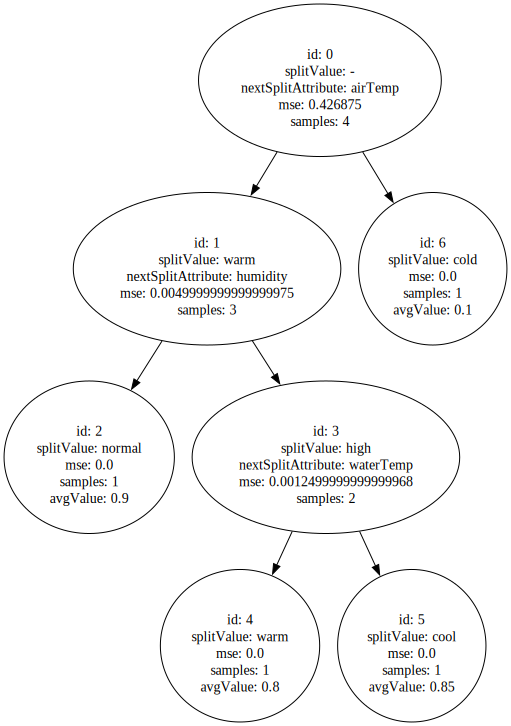

In [35]:
# visualising in the "bubble" format from the lecture
dot_data = id3.makeDotData().source
graph = graphviz.Source(dot_data, format="png")
graph.render(test_case+"_bubbles")
graph

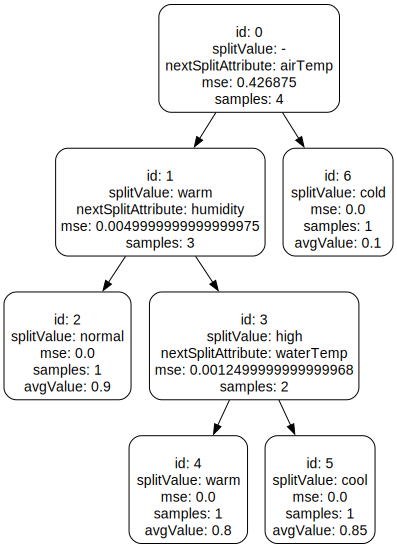

In [36]:
# printing to squares if you want a tree that looks more like those from part 1 ;-)
dot_data_pretty='digraph Tree {\n'+\
    'node [shape=box'+\
    ', style="rounded", color="black"'+\
    ', fontname="helvetica"] ;\n'+\
    'graph [ranksep=equally, splines=polyline] ;\n'+\
    'edge [fontname="helvetica"] ;\n'+\
    dot_data[9:]

graph = graphviz.Source(dot_data_pretty, format="png")
graph.render(test_case+"_pretty")
#graph.view()
graph

## Step3: Your own random forest!
Implement your own random forest (with at least N=5 trees) based on the ID3-implementation you worked with above. Use the best performing data binning from your experiments. As a reminder, the steps for the random forest creation are:
- bootstrap N new datasets from the binned *training* data you created above, sets for validation and test form already the remaining out-of-bootstrap data
- randomise the set of used attributes for each tree (clarification: do the randomisation per tree only, not for each split within the trees)
- create the N trees
- use an ensemble to get the final prediction (e.g. *weighted averaging based on the score for each tree*, for example - NOTE: remember that scores can be negative!)
- evaluate on the out-of-bootstrap data

Motivate your choices and prepare for explaining your implementation in detail!


In [44]:
# -------------------------- IMPLEMENTATION TASK BELOW THIS LINE ------------------------  
# Implement a random forest based on the ID3 implementation for a regression tree. 
# Evaluate in a fair manner (explain your choice!) against the SKLearn Random Forest you created 
# in Part 1 of the assignment.
# ...

# dummy values, so that the visualisation works, see below
# number_of_trees = 2
# trees_in_forest = [id3, id3]
# ====== Random Forest on ConceptData (clean version, no duplicates) ======
binned_X_train = np.array(binned_X_train)
binned_X_test  = np.array(binned_X_test)
y_train        = np.array(y_train)
y_test         = np.array(y_test)

N_TREES = 3                     # checklist example uses 3
n_samples = len(binned_X_train)
all_attributes = list(attributes.keys())

trees_in_forest = []
tree_scores = []
used_attrs_per_tree = []
used_indices_per_tree = []


print("\n===== Building ID3 Random Forest on ConceptData =====\n")
np.random.seed(0)          # 放在 for t in range(N_TREES) 之前
for t in range(N_TREES):

    print(f"\n--- Tree {t} ---")

    # ---- Bootstrap sampling ----
    bootstrap_idx = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
    oob_idx = np.setdiff1d(np.arange(n_samples), bootstrap_idx)
    
    X_bootstrap = binned_X_train[bootstrap_idx]
    y_bootstrap = y_train[bootstrap_idx]

    print("bootstrapped X for tree", t, ":")
    print(X_bootstrap)
    print("bootstrapped Y:", y_bootstrap)

    # ---- Random subset of attributes (2 attrs per tree for ConceptData) ----
    selected_attrs = list(np.random.choice(all_attributes, size=2, replace=False))
    used_attrs_per_tree.append(selected_attrs)

    print("attributes used for tree", t, ":", selected_attrs)

    # Subset attribute dictionary and corresponding feature columns
    attr_dict = {a: attributes[a] for a in selected_attrs}
    attr_indices = [all_attributes.index(a) for a in selected_attrs]
    used_indices_per_tree.append(attr_indices)

    # Slice bootstrap/OOB data to the chosen attribute columns
    X_bootstrap_sub = X_bootstrap[:, attr_indices]

    # ---- Train ID3 ----
    tree = ID3_reg.ID3RegressionTreePredictor()
    tree.fit(X_bootstrap_sub, y_bootstrap, attr_dict, selected_attrs)
    trees_in_forest.append(tree)

    # ---- Evaluate on OOB set ----
    if len(oob_idx) > 0:
        X_oob = binned_X_train[oob_idx]
        y_oob = y_train[oob_idx]
        X_oob_sub = X_oob[:, attr_indices]
        oob_pred = tree.predict(X_oob_sub)
        
        # Checklist-friendly scoring: negative MSE instead of R²
        score = -np.mean((oob_pred - y_oob)**2)
    else:
        score = -1  # reasonable default


    tree_scores.append(score)
    print("OOB score:", score)

print("\n===== Individual Tree Scores =====")
print(tree_scores)

# ====== Ensemble prediction on test data ======

weights = np.array(tree_scores)
weights = weights - np.min(weights) + 1e-6      # shift to positive weights

all_preds = []
for tree, idxs in zip(trees_in_forest, used_indices_per_tree):
    X_test_sub = binned_X_test[:, idxs]
    all_preds.append(tree.predict(X_test_sub))
all_preds = np.array(all_preds)
ensemble_pred = np.average(all_preds, axis=0, weights=weights)
final_rf_score = id3_score(ensemble_pred, y_test)

print("\n===== FINAL ID3 Random Forest PERFORMANCE =====")
print("Ensemble Test R²:", final_rf_score)



===== Building ID3 Random Forest on ConceptData =====


--- Tree 0 ---
bootstrapped X for tree 0 :
[['strong' 'warm' 'normal' 'sunny' 'warm' 'same']
 ['strong' 'warm' 'high' 'sunny' 'cool' 'change']
 ['strong' 'warm' 'high' 'sunny' 'warm' 'same']
 ['strong' 'warm' 'normal' 'sunny' 'warm' 'same']]
bootstrapped Y: [0.9  0.85 0.8  0.9 ]
attributes used for tree 0 : [np.str_('wind'), np.str_('humidity')]
leaf, not enough samples, setting node-value = 0.0
OOB score: -0.525625

--- Tree 1 ---
bootstrapped X for tree 1 :
[['strong' 'warm' 'high' 'sunny' 'warm' 'same']
 ['strong' 'cold' 'high' 'rainy' 'warm' 'change']
 ['strong' 'warm' 'normal' 'sunny' 'warm' 'same']
 ['strong' 'warm' 'high' 'sunny' 'cool' 'change']]
bootstrapped Y: [0.8  0.1  0.9  0.85]
attributes used for tree 1 : [np.str_('sky'), np.str_('airTemp')]
leaf, not enough samples, setting node-value = 0.0
leaf, not enough samples, setting node-value = 0.0
OOB score: -1

--- Tree 2 ---
bootstrapped X for tree 2 :
[['strong' 'cold

In [45]:
# One way of visualising your forest - there might be smarter versions!
# OBS: this code assumes number_of_trees and a list with the trees called trees_in_forest
# adapt if needed!

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


graph = []
img_path = []

for i in range(number_of_trees):
    graph.append(graphviz.Source(trees_in_forest[i].makeDotData().source, format="png"))
    img_path.append("forest_"+test_case+str(i))
    graph[i].render(img_path[i])
    
fig, axs = plt.subplots(number_of_trees,1,figsize=(100,100)) # use plt.subplots(number_of_trees/2,2) if you want two columns
for i, axi in enumerate(axs.flat):
    axi.set_title("Tree {}".format(i))
    
    img = mpimg.imread(img_path[i]+".png")
    axi.imshow(img)
fig.tight_layout()
    

